In [0]:
# computation dependancies
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

# preprocessing dependancies
import torchvision
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from skimage.transform import resize

# visualization dependancies
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.grid'] = False
from PIL import Image
import PIL.ImageOps as ImageOps
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
assert torch.cuda.is_available()
precision = 4
torch.set_printoptions(precision,sci_mode=False)
np.set_printoptions(precision,suppress=True)

In [7]:
# downloads data from torchvision dataset
official_mnist_train = torchvision.datasets.MNIST(root = 'HOME/data/mnist', train=True, download=True);
official_train_images = official_mnist_train.data.numpy().astype(np.float32);
official_train_labels = official_mnist_train.targets.numpy().astype(np.int);

# prints data specifications...number of examples, image height, image width, and number of classes
print('shape (num_examples, image_height, image_width)', official_train_images.shape)
print('classes %d to %d' %(np.min(official_train_labels),np.max(official_train_labels)))

0it [00:00, ?it/s]

9920512it [00:01, 9566259.89it/s]                            


Extracting HOME/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to HOME/data/mnist/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142448.44it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting HOME/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to HOME/data/mnist/MNIST/raw


1654784it [00:00, 2333092.25it/s]                            
0it [00:00, ?it/s]

Extracting HOME/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to HOME/data/mnist/MNIST/raw


8192it [00:00, 51334.45it/s]            

Extracting HOME/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to HOME/data/mnist/MNIST/raw
Processing...
Done!
shape (num_examples, image_height, image_width) (60000, 28, 28)
classes 0 to 9


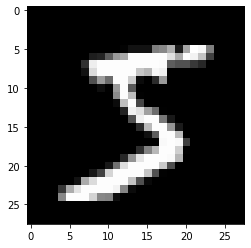

In [8]:
# first image
plt.imshow(official_train_images[0],cmap='gray')

[5 0 4 1 9 2 1 3 1 4]


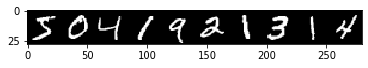

In [9]:
# peek at the first 10 data entries
example_images = np.concatenate(official_train_images[:10], axis=1)
example_labels = official_train_labels[:10]
print(example_labels)
plt.imshow(example_images,cmap='gray')

In [10]:
k_fold = KFold(n_splits = 5, shuffle = True)
for train_index, test_index in k_fold.split(official_train_images):
  data_train, data_test = official_train_images[train_index], official_train_images[test_index]
  labels_train, labels_test = official_train_labels[train_index], official_train_labels[test_index]
  break
print(data_train.shape)
print(data_test.shape)  

(48000, 28, 28)
(12000, 28, 28)


In [0]:
# function to normalize images of shape (num_examples,height,width)
def normalize_images(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / stdev

In [12]:
data_train = normalize_images(data_train)
data_test = normalize_images(data_test)
print(np.mean(data_train))
print(np.std(data_train))

-2.4237196e-10
0.9999995


In [0]:
# Dataset Creation Class
class ImageDataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

  def __len__ (self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    image = torch.from_numpy(np.expand_dims(self.data[idx],axis=0)).cuda()
    target = torch.from_numpy(np.asarray(self.labels[idx])).cuda()

    item = {'image': image, 'target': target}
    return item

In [0]:
class SimpleCNN(torch.nn.Module):
  """A simple convolutional network.
  
  Map from inputs with shape [batch_size, 1, height, width] to
  outputs with shape [batch_size, 1].
  """
  
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=7, padding=7//2) # feel free to change these parameters.
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=3//2, stride = 3)
    self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=3//2)
    self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=3//2, stride = 3)
    self.conv5 = torch.nn.Conv2d(128, 128, kernel_size=4, padding = 0, stride = 1)    
    # Final layer maps to 10 outputs which are the 10 classes
    self.conv_final = torch.nn.Conv2d(128, 128, kernel_size=1)
    self.linear1 = torch.nn.Linear(128,128)
    self.linear2 = torch.nn.Linear(128,10)
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        m.reset_parameters()
        torch.nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
          m.bias.data.zero_()
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    # output (28 - 7 + 6) / 1 + 1 = 28 x 28 x 32
    x = F.relu(self.conv2(x))
    # output (28 - 3 + 2) / 3 + 1 = 10 x 10 x 32
    x = F.relu(self.conv3(x))
    # output 10 x 10 x 32
    x = F.relu(self.conv4(x))
    # output (10-3+2) / 3 + 1 = 4 x 4 x 32
    x = F.relu(self.conv5(x))
    x = self.conv_final(x)
    x = x.squeeze()
    x = self.linear1(x)
    x = self.linear2(x)
    return x

![alt text](https://miro.medium.com/max/1204/1*TVu5hyywTrUsCAkfJbVHQw.png)

In [0]:
def train_step(batch_size=128):
  global dataloader_train_enumerate

  model.train()

  try:
    i_batch,item_batch = next(dataloader_train_enumerate)
    input_batch = item_batch['image']
    label_batch = item_batch['target']
  except StopIteration:
    dataset_train = ImageDataset(data_train, labels_train)
    dataloader_train_enumerate = enumerate(DataLoader(dataset_train, batch_size = batch_size, shuffle=True))
    i_batch,item_batch = next(dataloader_train_enumerate)
    input_batch = item_batch['image']
    label_batch = item_batch['target']

  output_batch = model(input_batch)

  loss = nn.CrossEntropyLoss()
  loss = loss(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()

  optimizer.zero_grad()
  loss.backward()
  
  optimizer.step()
  return loss.item(), error_rate.item()

In [0]:
def val():
  global dataloader_test_enumerate
  model.eval()

  try:
    i_batch,item_batch = next(dataloader_test_enumerate)
    input_batch = item_batch['image']
    label_batch = item_batch['target']
  except StopIteration:
    dataset_test = ImageDataset(data_test, labels_test)
    dataloader_test_enumerate = enumerate(DataLoader(dataset_test, batch_size = val_batch_size, shuffle=True))
    i_batch,item_batch = next(dataloader_test_enumerate)
    input_batch = item_batch['image']
    label_batch = item_batch['target']

  output_batch = model(input_batch)

  loss = nn.CrossEntropyLoss()
  loss = loss(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  
  return loss.item(), error_rate.item()

In [0]:
# part of filter visualization code
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.cpu().detach().numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/5, nrows/100))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [0]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.cpu().detach().numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].cpu().detach().numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [0]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = list(model.modules())[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = list(list(model.modules())[layer_num].parameters())[0]
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

Step     0: Obtained a best validation error of 0.8680.
Step    50: Obtained a best validation error of 0.0920.
Step   100: Obtained a best validation error of 0.0600.
Step   150: Obtained a best validation error of 0.0460.
Step   200: Obtained a best validation error of 0.0260.
Step   250: Obtained a best validation error of 0.0240.
Step   400: Obtained a best validation error of 0.0200.
Step   500: Obtained a best validation error of 0.0080.
Step   950: Obtained a best validation error of 0.0020.


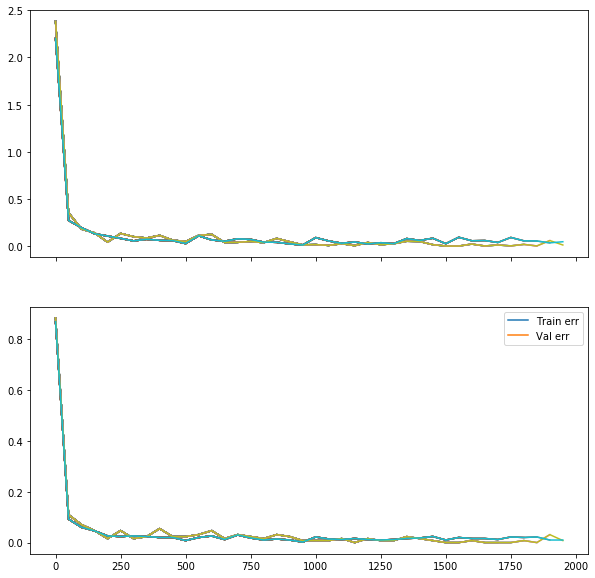

In [310]:
# Hyperparameters
batch_size = 128
val_batch_size = 500
lr = .001


# instantiates neural network model
model = SimpleCNN()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

dataset_train = ImageDataset(data_train, labels_train)
dataset_test = ImageDataset(data_test, labels_test)

# dataloader objects and enumerate for train and test datasets
dataloader_train_enumerate = enumerate(DataLoader(dataset_train, batch_size = batch_size, shuffle=True))
dataloader_test_enumerate = enumerate(DataLoader(dataset_test, batch_size = val_batch_size, shuffle=True))

info = []
fig, axs = plt.subplots(2,1,sharex='col',figsize = (10,10))
num_steps = 2000
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  if step % num_steps_per_val == 0:
    val_loss, val_err = val()
    if val_err < best_val_err:
      best_val_err = val_err
      print('Step {:5d}: Obtained a best validation error of {:.4f}.'.format(step, best_val_err))
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)
    axs[0].plot(x, y11, x, y12)
    plt.legend(['Train loss', 'Val loss'])
    axs[1].plot(x, y21, x, y22)
    plt.legend(['Train err', 'Val err'])


[12.103  -4.1994 -0.2987 -3.5229 -2.8213  1.0188  0.0402  3.4523 -6.3146
  3.3674]
tensor(0, device='cuda:0')


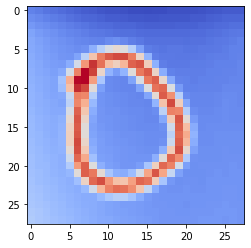

In [329]:
# tests personal handwritten images
model.eval()
test_image = ImageOps.invert(Image.open('/content/drive/My Drive/Colab_Notebooks/Data/Handwritten/handwritten_0.jpg').convert('L'))
test_image = np.array((test_image.resize((28,28),resample=4)))
test_image = np.expand_dims(test_image,axis=0)
test_image = normalize_images(test_image)
test_image_imshow = test_image.squeeze()
plt.imshow(test_image_imshow,cmap='coolwarm')
test_image = torch.from_numpy(test_image).type(torch.FloatTensor).cuda()
test_image = test_image.unsqueeze(0).cuda()

output_batch = model(test_image)
print((output_batch.cpu().detach().numpy()))
_, pred_batch = torch.max(output_batch, dim=0)
print(pred_batch)

In [312]:
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv_final): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (linear1): Linear(in_features=128, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)


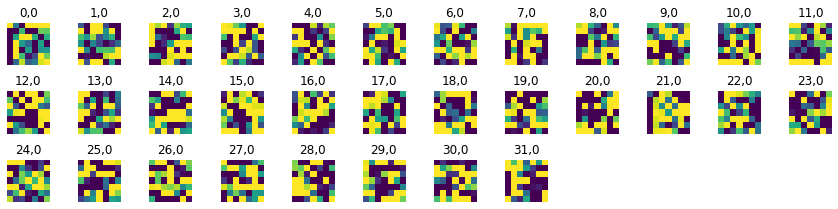

In [313]:
plot_weights(model, 1, single_channel=True)

In [0]:
# code to visualize class activations
#custom function to conduct occlusion experiments

def occlusion(model, image, label, occ_size = 1, occ_stride = 1, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=0)
            prob = output.tolist()[label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

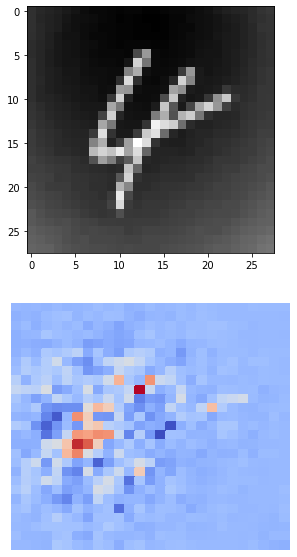

In [315]:
heatmap = occlusion(model, test_image, 9)
fig,axs = plt.subplots(2,1,figsize = (5,10))
axs[0].imshow(test_image_imshow,cmap='gray')
axs[1] = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, cmap='coolwarm', cbar=False)

In [0]:
# # downsamples too harshly
# test_image = Image.open('test_image.jpg').convert('L')
# test_image = ToTensor()(test_image.resize((28,28)))
# test_image = normalize_images(test_image.)
# plt.imshow(test_image.squeeze())
# test_image = test_image.unsqueeze(0).cuda()

In [0]:
# layer = 0
# param_int = 0
# for m in model.modules():
#     if isinstance(m, nn.Conv2d):
#       layer +=1
#       print('layer', layer)
#       if layer == 5:
#         plt.imshow(m.parameters()[0][0].cpu().detach().numpy())
#       for param in m.parameters():
#         param_int += 1
#         print('param',param_int)
#         print(param.size())

# # code to visualize input and predictions
#   if step == 200:
#     print(pred_batch)
#     print(input_batch.size())
#     input_images = input_batch.squeeze().cpu().detach().numpy()
#     input_images = input_images.reshape(10,10,28,28)
#     input_images = np.concatenate(input_images,axis=1)
#     input_images = np.concatenate(input_images,axis=1)
#     ax[2].imshow(input_images)
#     plt.figure(figsize=(20,20))
#     plt.show()

# #
# test_image[test_image < 0 ] = 0
# test_image[test_image > 1.4 ] = 5